In [1]:
from src.Utilities.isalice import isalice
alice, plot = isalice()

# Vanilla imports
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# Chocolate Imports
from src.Opacity.opacity_table import opacity
from src.Calculators.ray_tree import ray_maker
from src.Luminosity.special_radii_tree import get_specialr
from src.Calculators.select_observers import select_observer 
from src.Luminosity.select_path import select_snap
from datetime import datetime
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [5 , 4]
pre = '/home/s3745597/data1/TDE/tde_comparison'

# Constants
c = 2.99792458e10 #[cm/s]
h = 6.62607015e-27 #[gcm^2/s]
Kb = 1.380649e-16 #[gcm^2/s^2K]
alpha = 7.5646 * 10**(-15) # radiation density [erg/cm^3K^4]
Rsol_to_cm = 6.957e10

In [2]:
def log_array(n_min, n_max, lenght):
    x_min = np.log10(n_min)
    x_max = np.log10(n_max)
    x_arr = np.linspace(x_min, x_max , num = lenght)
    return x_arr

def planck(Temperature: float, n: float) -> float:
    """ Planck function in a cell. It needs temperature and frequency n. """
    const = 2*h/c**2
    fun = const * n**3 / (np.exp(h*n/(Kb*Temperature))-1)

    return fun

def luminosity_n(Temperature: float, Density: float, tau: float, volume: float, n: float):
    """ Luminosity in a cell: L_n = \epsilon e^(-\tau) B_n / B 
    where  B = \sigma T^4/\pi"""
    T_high = np.exp(17.87)
    if Temperature > T_high:
        Tmax = np.exp(17.87)
        # Scale as Kramers the last point 
        kplank_0 = opacity(Tmax, Density, 'planck', ln = False)
        k_planck = kplank_0 * (Temperature/Tmax)**(-3.5)
    else:
        k_planck = opacity(Temperature, Density, 'planck', ln = False)

    L = 4  * np.pi * k_planck * volume * np.exp(-tau) * planck(Temperature, n)
    return L

def normalisation(L_x: np.array, x_array: np.array, luminosity_fld: float) -> float:
    """ Given the array of luminosity L_x computed over n_array = 10^{x_array} (!!!), 
    find the normalisation constant for L_tilde_n from FLD model. """  
    xLx =  10**(x_array) * L_x
    L = np.trapz(xLx, x_array) 
    L *= np.log(10)
    norm = luminosity_fld / L
    return norm

def find_sph_coord(theta,phi):
    x = np.sin(np.pi-theta) * np.cos(phi) #because theta should start from the z axis: we're flipped
    y = np.sin(np.pi-theta) * np.sin(phi)
    z = np.cos(np.pi-theta)
    xyz = [x, y, z]
    return xyz

def normalisation(L_x: np.array, x_array: np.array, luminosity_fld: float) -> float:
    """ Given the array of luminosity L_x computed over n_array = 10^{x_array} (!!!), 
    find the normalisation constant for L_tilde_n from FLD model. """  
    xLx =  10**(x_array) * L_x
    L = np.trapz(xLx, x_array) 
    L *= np.log(10)
    norm = luminosity_fld / L
    return norm

In [3]:
# Choose BH 
m = 6
check = 'fid'
num = 1000
snapshots, days = select_snap(m, check)

# Load data for normalsation 
fld_data = np.loadtxt('data/red/reddata_m'+ str(m) + check +'.txt')
luminosity_fld_fix = fld_data[1]

# Choose freq range
n_min = 2.08e13
n_max = 6.25e23
n_spacing = 100 # Elad used 1000, but no difference
x_arr = log_array(n_min, n_max, n_spacing)
n_arr = 10**x_arr

In [4]:
# Choose the observers: theta in [0, pi], phi in [0,2pi]
wanted_thetas = [np.pi/2, np.pi/2, np.pi/2, np.pi/2, np.pi, 0] # x, -x, y, -y, z, -z
wanted_phis = [0, np.pi, np.pi/2, 3*np.pi/2, 0, 0]

Text(0.5, 0.92, 'Wanted observers')

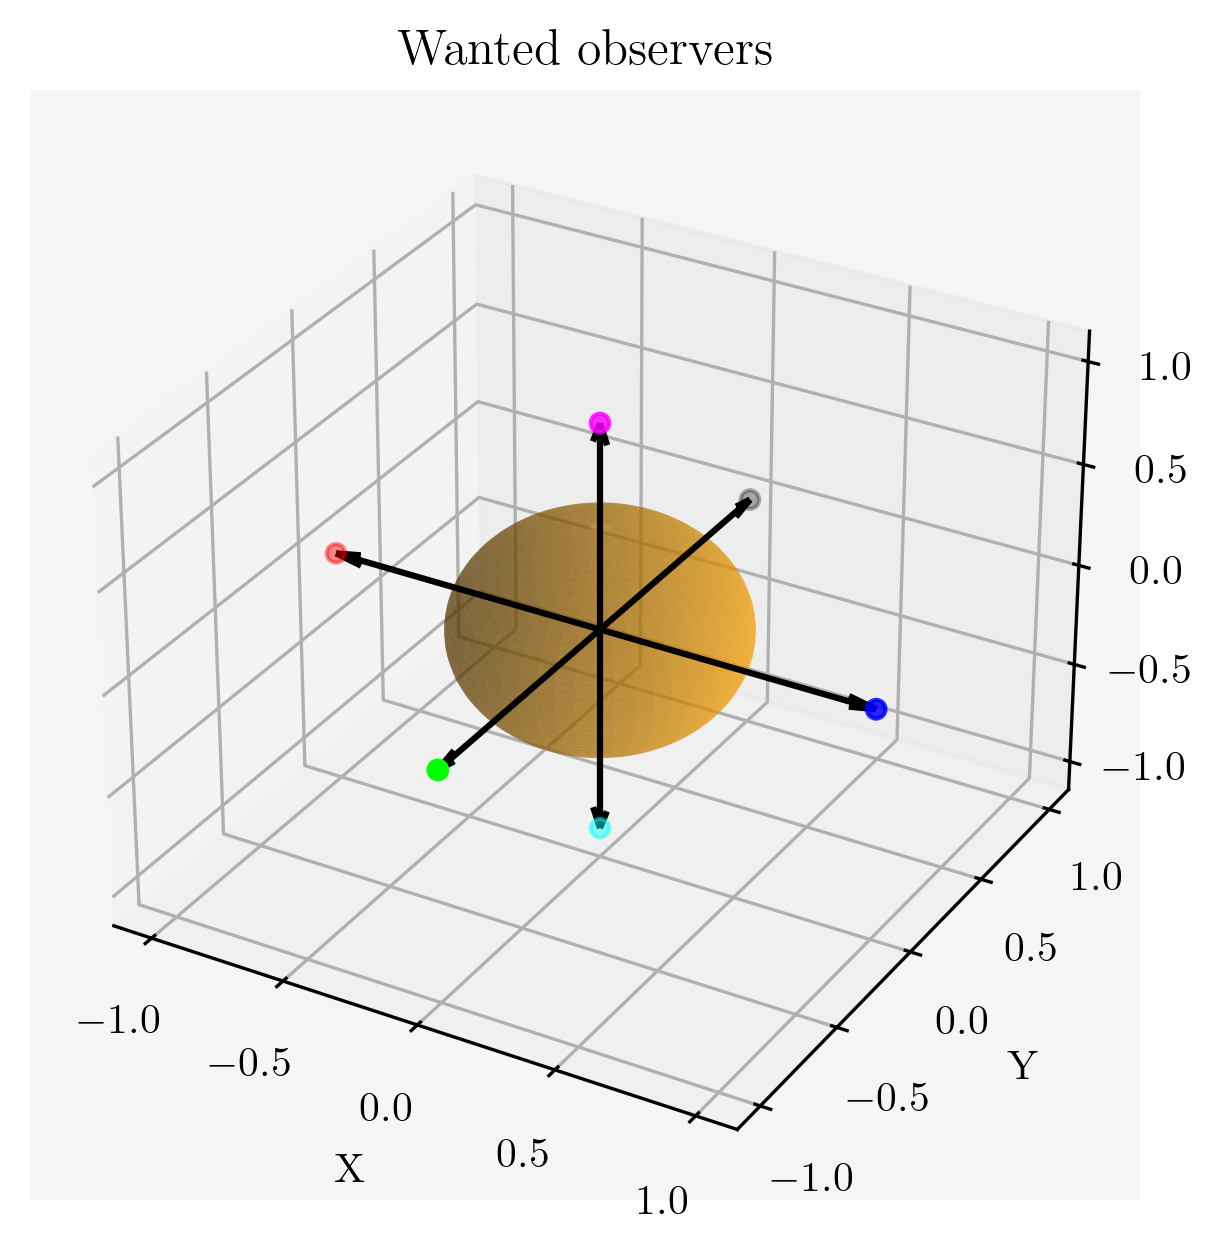

In [5]:
x_wanted = np.zeros(len(wanted_thetas))
y_wanted = np.zeros(len(wanted_thetas))
z_wanted = np.zeros(len(wanted_thetas)) 
for i in range(len(wanted_thetas)):
    x_wanted[i], y_wanted[i], z_wanted[i] = find_sph_coord(wanted_thetas[i], wanted_phis[i])

# Plot the ones chosen 
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
# Create a sphere
r = 0.5
phi_sph, theta_sph = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]
x = r*np.sin(phi_sph)*np.cos(theta_sph)
y = r*np.sin(phi_sph)*np.sin(theta_sph)
z = r*np.cos(phi_sph)
ax.plot_surface(x, y, z, color='orange', alpha = 0.5)

#Set arrow for axis
xar = np.zeros(len(x_wanted))
yar = np.zeros(len(x_wanted))
zar = np.zeros(len(x_wanted))
# ax.quiver(xar,yar,zar, dx, dy, dz, arrow_length_ratio=0.1, color = 'k')
col = ['b', 'r', 'k', 'lime', 'magenta', 'aqua']
ax.quiver(xar, yar, zar, x_wanted, y_wanted, z_wanted, arrow_length_ratio=0.1, color = 'k')

ax.scatter(x_wanted,y_wanted,z_wanted, color = col, s=20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.tight_layout()
plt.title('Wanted observers')

X: [ 0.98078528 -0.98078528 -0.19509032  0.19509032  0.36923088  0.36923088]
Y: [ 0.19509032 -0.19509032  0.98078528 -0.98078528  0.15294044  0.15294044]
Z: [ 6.12323400e-17  6.12323400e-17  6.12323400e-17  6.12323400e-17
  9.16666667e-01 -9.16666667e-01]


Text(0.5, 0.92, 'Healpix observers')

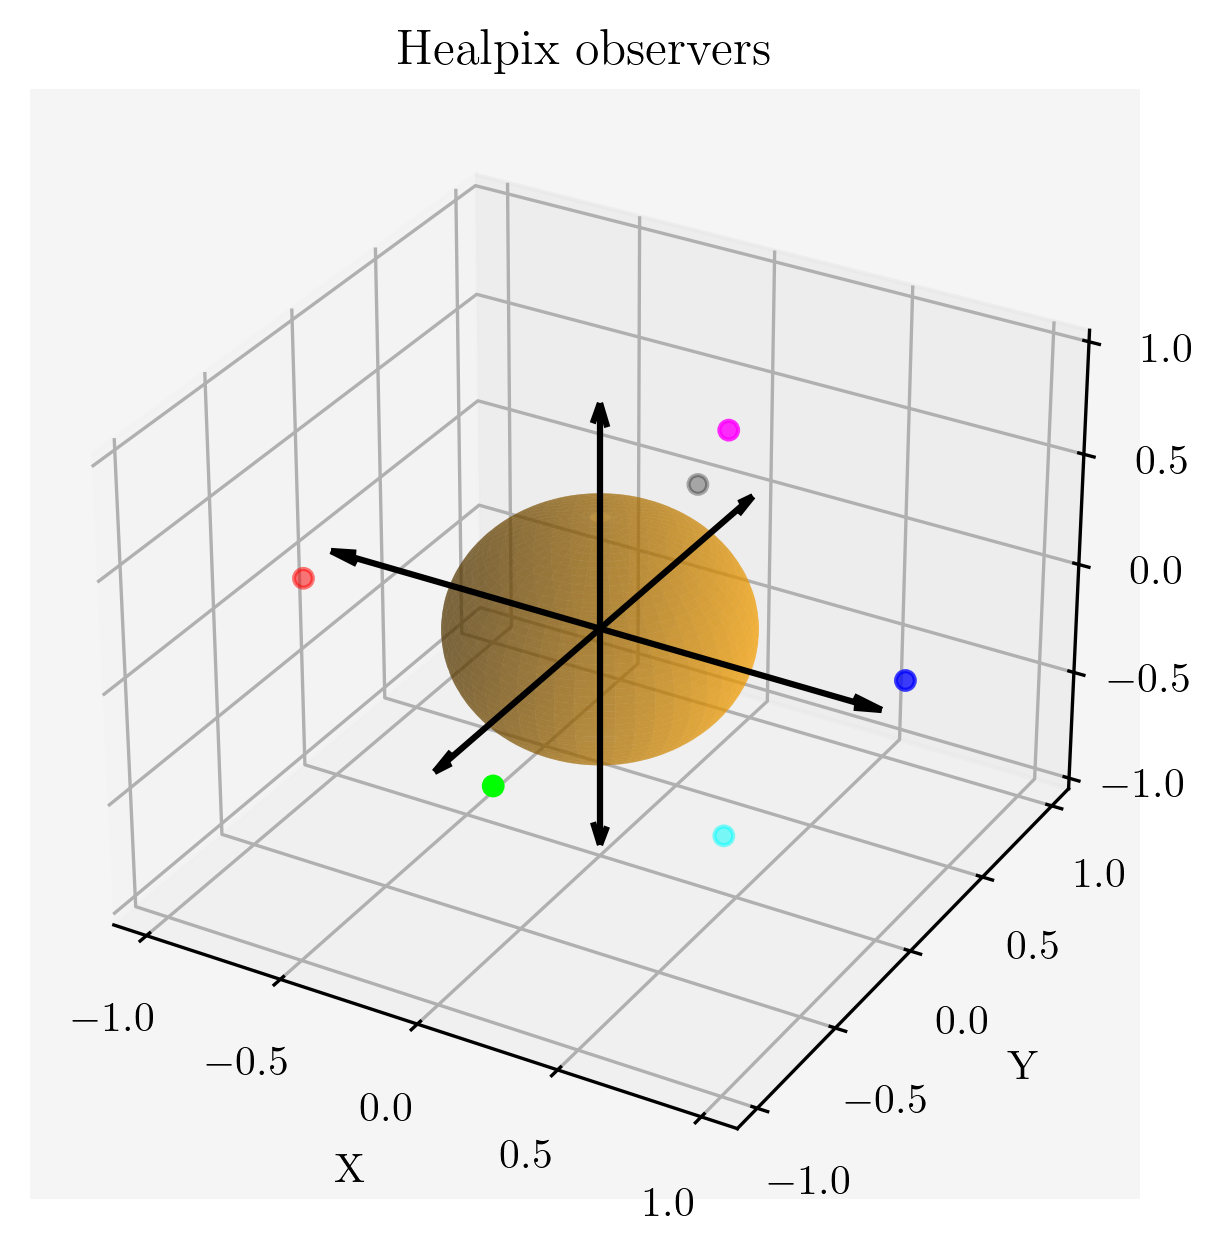

In [6]:
thetas = np.zeros(192)
phis = np.zeros(192) 
for i in range(0,192):
    thetas[i], phis[i] = hp.pix2ang(4, i)

x_selected = np.zeros(len(wanted_thetas))
y_selected = np.zeros(len(wanted_thetas))
z_selected = np.zeros(len(wanted_thetas))
for idx in range(len(wanted_thetas)):
    wanted_theta = wanted_thetas[idx]
    wanted_phi = wanted_phis[idx]
    wanted_index = select_observer(wanted_theta, wanted_phi, thetas, phis)
    x_selected[idx], y_selected[idx], z_selected[idx] = find_sph_coord(thetas[wanted_index], phis[wanted_index])

print('X:' , x_selected)
print('Y:' , y_selected)
print('Z:' , z_selected)

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
# Create a sphere
r = 0.5
phi_sph, theta_sph = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]
x = r*np.sin(phi_sph)*np.cos(theta_sph)
y = r*np.sin(phi_sph)*np.sin(theta_sph)
z = r*np.cos(phi_sph)
ax.plot_surface(x, y, z, color='orange', alpha = 0.5)

#Set arrow for axis
xar = np.zeros(len(x_wanted))
yar = np.zeros(len(x_wanted))
zar = np.zeros(len(x_wanted))
# ax.quiver(xar,yar,zar, dx, dy, dz, arrow_length_ratio=0.1, color = 'k')
col = ['b', 'r', 'k', 'lime', 'magenta', 'aqua']
ax.quiver(xar, yar, zar, x_wanted, y_wanted, z_wanted, arrow_length_ratio=0.1, color = 'k')

ax.scatter(x_selected,y_selected,z_selected, color = col, s=20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.tight_layout()
plt.title('Healpix observers')

In [7]:
snap = 881

# Find observers 
tree_indexes, observers, rays_T, rays_den, _, radii, rays_vol = ray_maker(snap, m, check, num)
thetas = np.zeros(192)
phis = np.zeros(192) 
for iobs in range(len(observers)): 
    thetas[iobs] = observers[iobs][0]
    phis[iobs] =  observers[iobs][1]

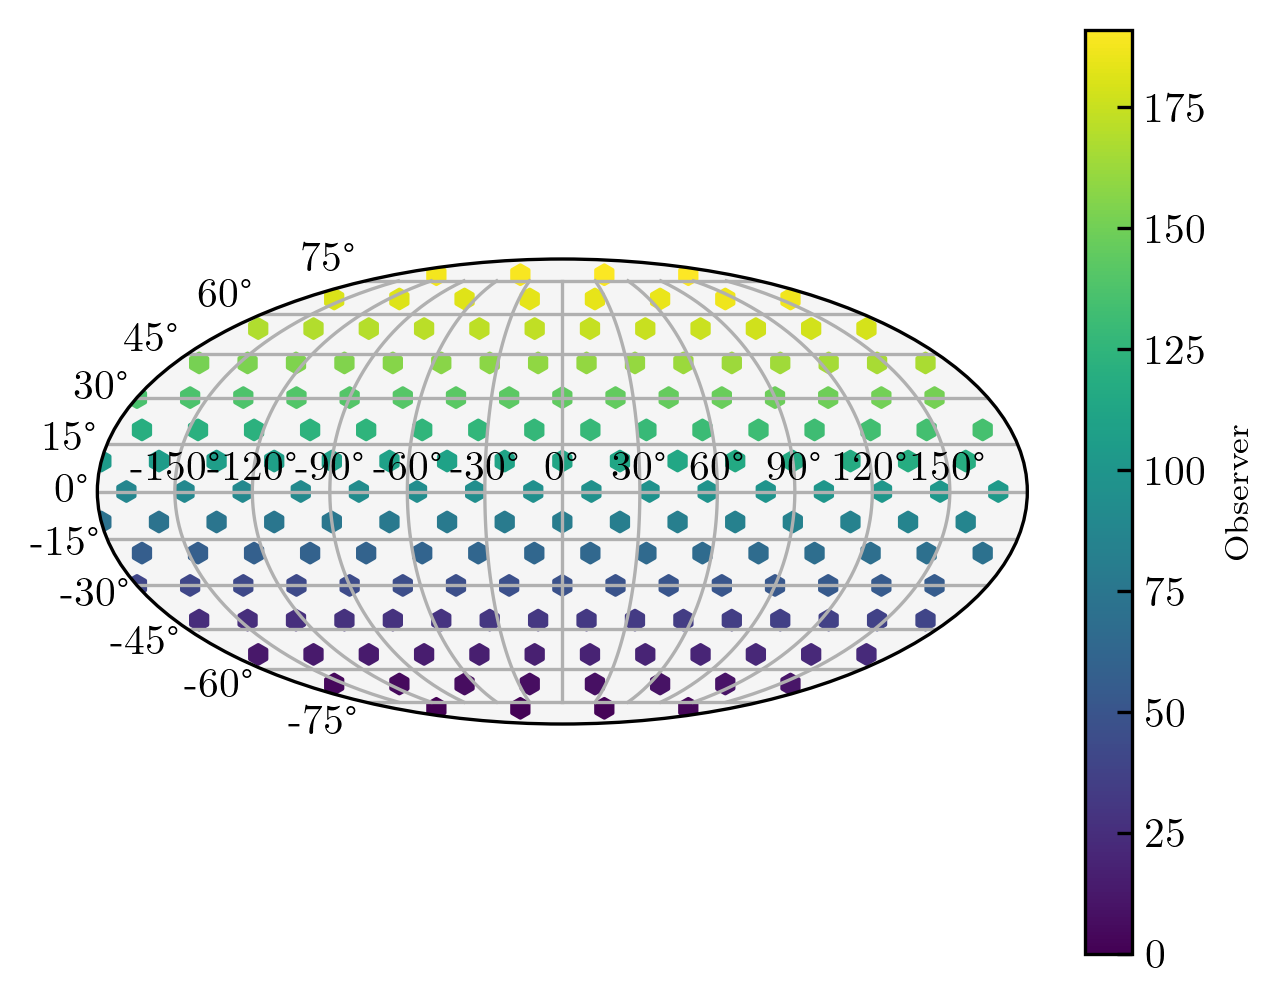

In [8]:
thetas_toplot= thetas - np.pi/2 # Enforce theta in -pi/2 to pi/2
phis_tolpot = phis- np.pi # Enforce theta in -pi to pi

fig, ax = plt.subplots(1,1, subplot_kw=dict(projection="mollweide"))
img = ax.scatter(phis_tolpot, thetas_toplot, c = np.arange(192), s=20, marker = 'h')
cbar = fig.colorbar(img)
cbar.set_label('Observer', fontsize = 8)
plt.grid(True)

Text(0.5, 1.0, 'Our radii')

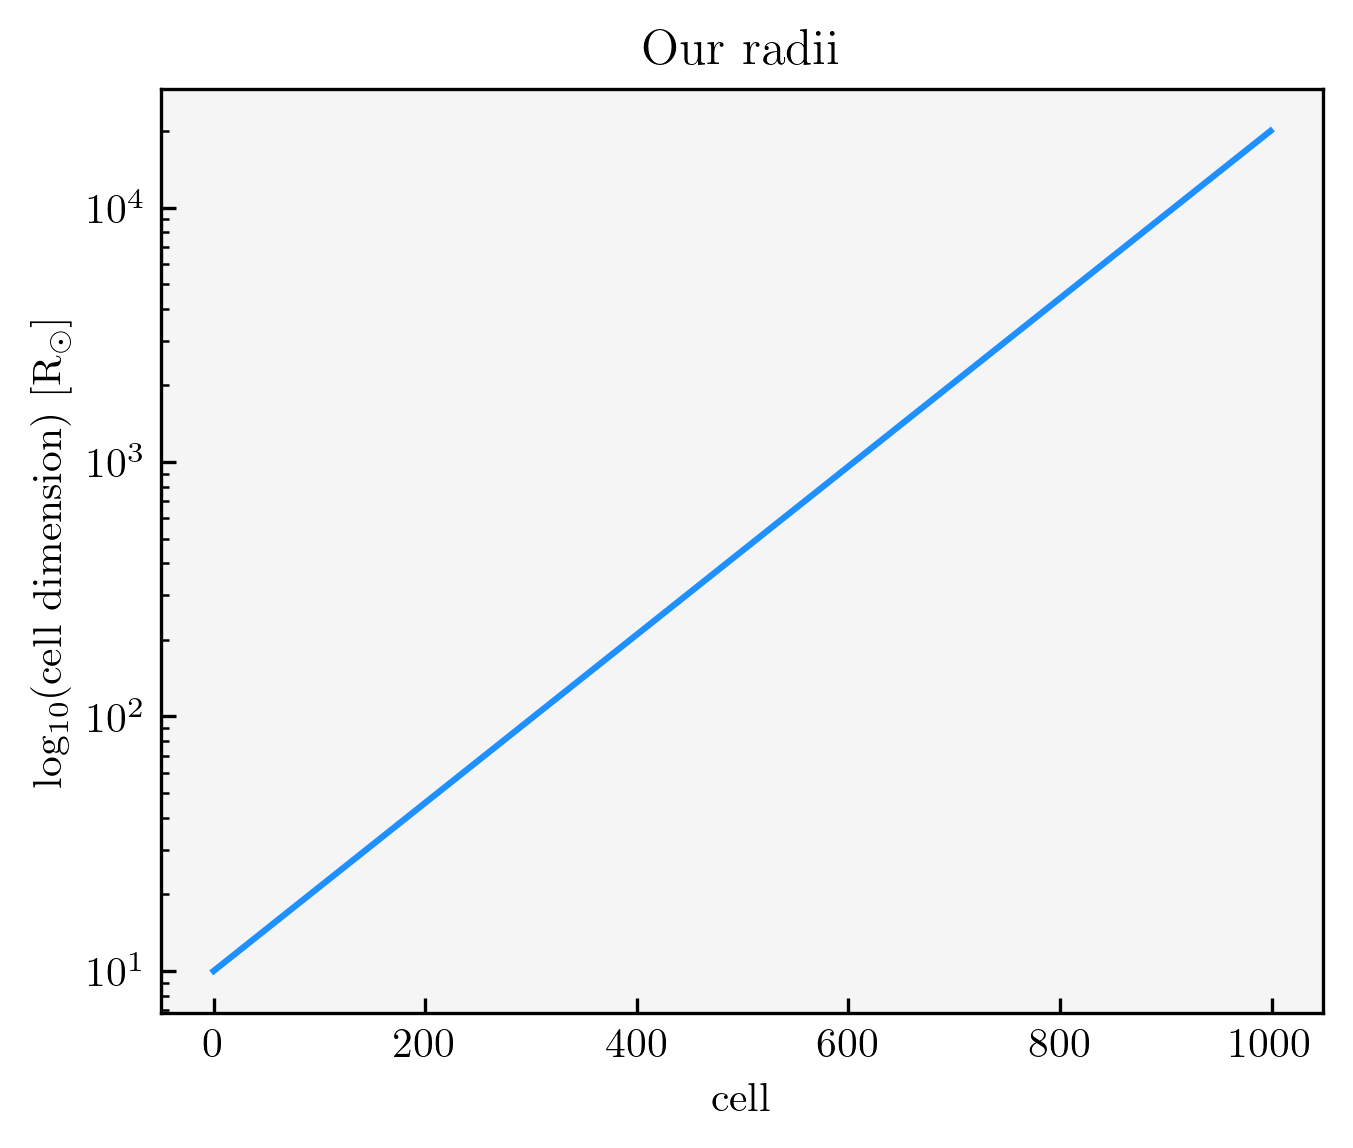

In [9]:
plt.figure()
plt.plot(np.arange(1000), radii/Rsol_to_cm, color = 'dodgerblue')
plt.yscale('log')
plt.xlabel('cell')
plt.ylabel(r'log$_{10}$(cell dimension) [R$_\odot$]')
plt.title('Our radii')

In [10]:
# Find voulume of cells
volume = np.zeros(len(radii)-1)
for i in range(len(volume)): 
    dr = radii[i+1] - radii[i]
    volume[i] = 4 * np.pi * radii[i]**2 * dr / 192  

Text(0.5, 1.0, 'Volume')

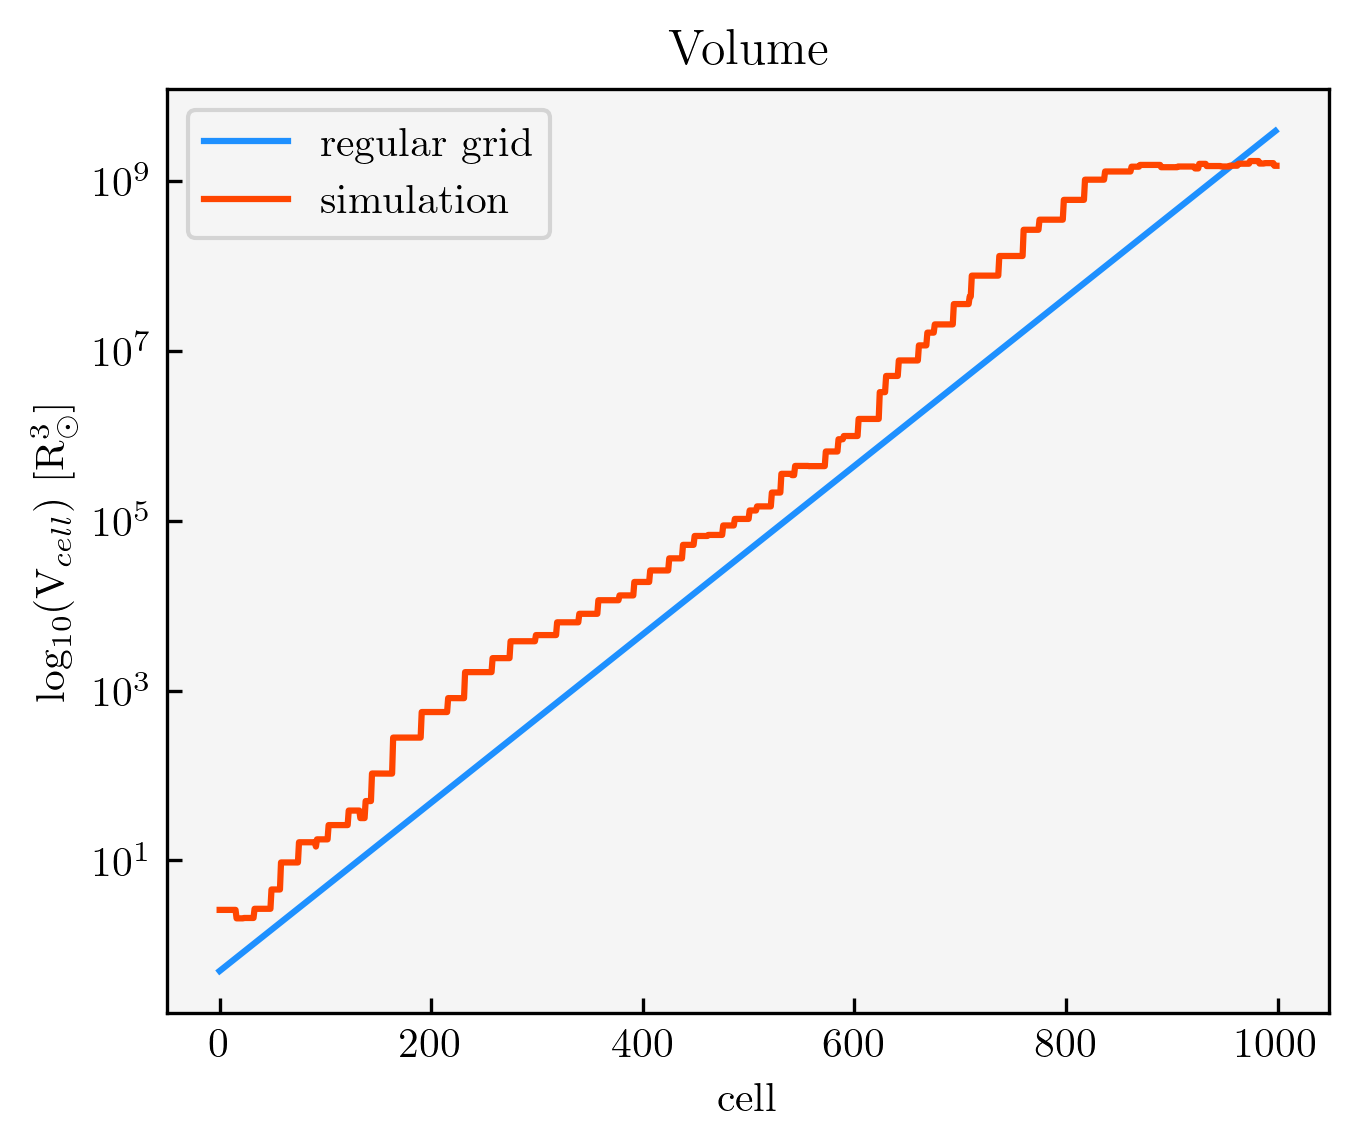

In [11]:
plt.figure()
plt.plot(np.arange(999), volume/Rsol_to_cm**3, color = 'dodgerblue', label = 'regular grid')
plt.plot(np.arange(1000), rays_vol[3], color = 'orangered', label = 'simulation')
plt.yscale('log')
plt.xlabel('cell')
plt.ylabel(r'log$_{10}$(V$_{cell}$) [R$^3_\odot$]')
plt.legend()
plt.title('Volume')

In [12]:
radii = np.delete(radii, -1)

In [13]:
# Get thermalisation radius
rays_kappas, rays_cumulative_taus, rays_specialr, rays_index_specialr, tree_index_specialr = get_specialr(rays_T, rays_den, radii, tree_indexes, select = 'thermr')

In [14]:
taus = np.zeros(192)
T_therm = np.zeros(192)
for i in range(192):
    taus[i] = rays_cumulative_taus[i][-1]
    T_therm[i] = tree_index_specialr[i]
print(taus)


[  6.33739766   5.09752646   9.05198634   5.0918913    6.60549753
   6.99213081   7.63785951   5.08548181   6.80801554   5.51507975
   5.4309286    5.41582454   6.48863269   6.4998206    7.60813221
   6.1502848    5.93445912   8.03530311   8.02070725  10.8151545
   5.83432497   5.21517221   5.11163159   6.59315968   7.64633328
   7.73617256   5.437643     9.1309056    5.6414329    6.60870199
   5.38719711   6.03560601   8.34585538   7.40098806   6.21019575
   7.34782664   6.45839824   6.3178694    6.13247744   5.27482489
   9.27849504   5.2967238    5.07290858   7.01268749   8.8661599
   5.25903477   5.94409489   6.17850376  15.37694397   9.6737366
   5.69236597   6.12220469   6.27914259   5.01456158   6.97847688
   5.52273287   5.83221154   7.83972742   8.45344836  19.92360769
   5.04611919   5.12959768   5.11468186   6.4711203    5.29195009
   5.11635002   9.81349079   6.24609717   5.42694063   5.56534335
   5.3658099    5.13675543  18.10770334 393.06119042   6.05830436
   5.83542178

58002693.08890143


Text(0.5, 0, 'observers')

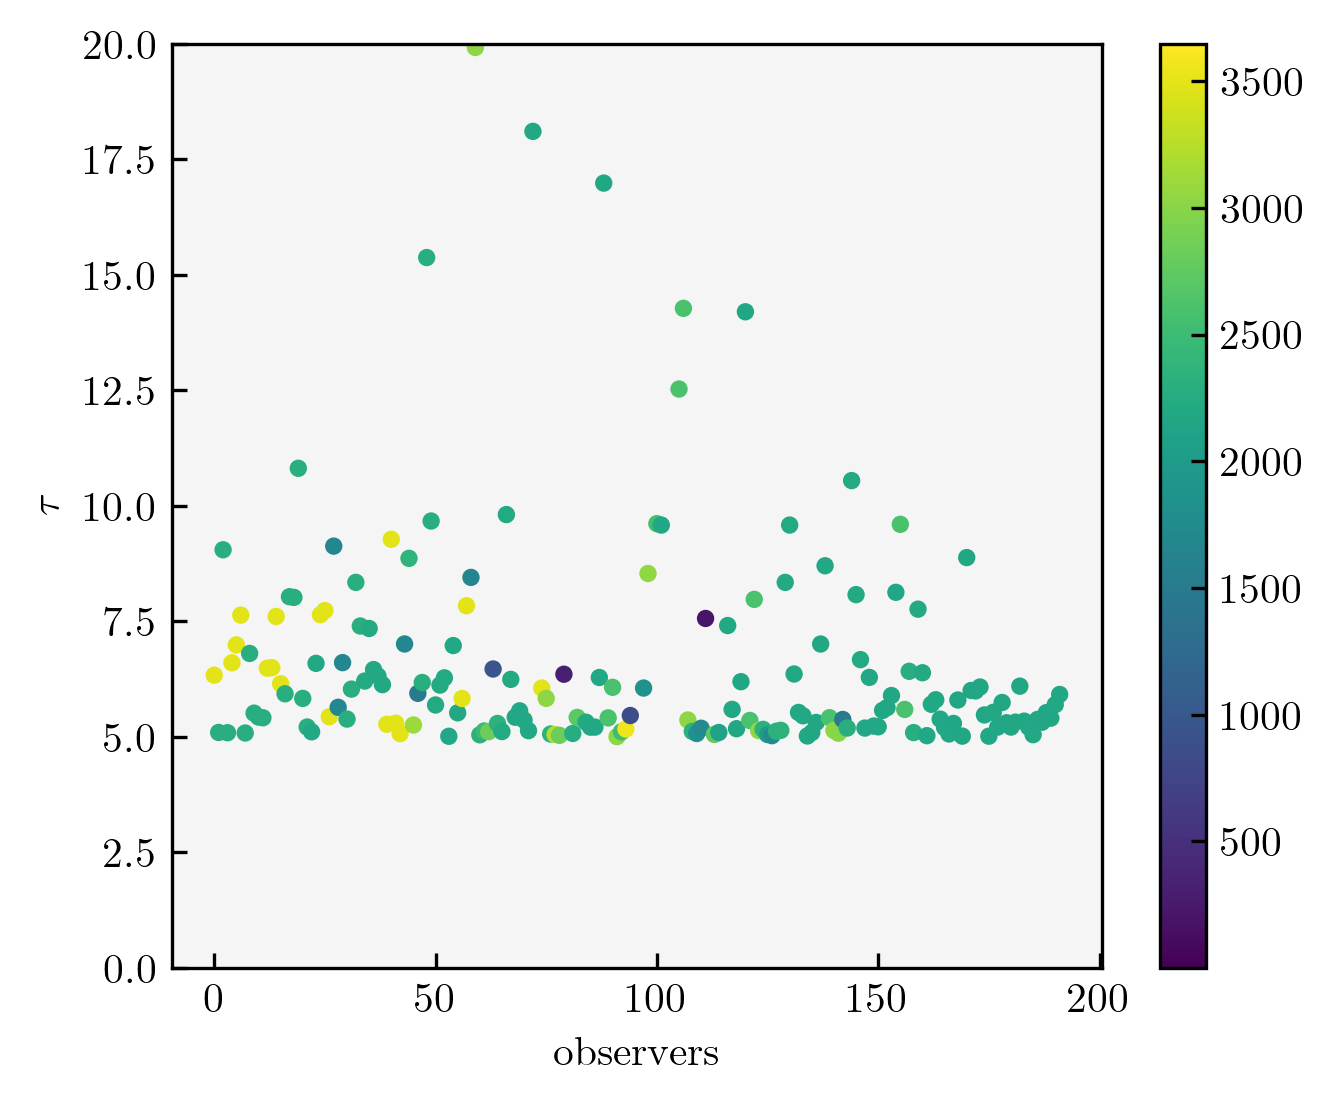

In [16]:
Tmin = np.exp(8.666)
Tmax = np.exp(17.876)
img = plt.scatter(np.arange(192), taus, s = 10, c = T_therm/Tmin, vmin = 1)
cbar = plt.colorbar(img)
plt.ylabel(r'$\tau$')
plt.ylim(0,20)
plt.xlabel('observers')

In [20]:
wanted_theta = wanted_thetas[1]
wanted_phi = wanted_phis[1]
wanted_index = select_observer(wanted_theta, wanted_phi, thetas, phis)
xyz_selected = find_sph_coord(thetas[wanted_index], phis[wanted_index])

In [33]:
dot_product = np.zeros(len(observers))
for iobs in range(len(observers)):
    xyz = find_sph_coord(thetas[iobs], phis[iobs])
    dot_product[iobs] = np.dot(xyz_selected, xyz)
# set the negative dot product to 0
    if dot_product[iobs] < 0:
        dot_product[iobs] = 0
dot_product *= 4/192 # normalisation from Elad

In [34]:
x_healpix = np.zeros(192)
y_healpix = np.zeros(192)
z_healpix = np.zeros(192)
for iobs in range(len(observers)): 
    thetas[iobs] = observers[iobs][0]
    phis[iobs] =  observers[iobs][1]
    x_healpix[iobs], y_healpix[iobs], z_healpix[iobs] = find_sph_coord(thetas[iobs], phis[iobs])

In [35]:
color_plot = []
for i in range(len(observers)):
    if dot_product[i] == 0:
        color_plot.append('k')
    else:
        color_plot.append('b')

Text(0.5, 0.92, 'Who do we take?')

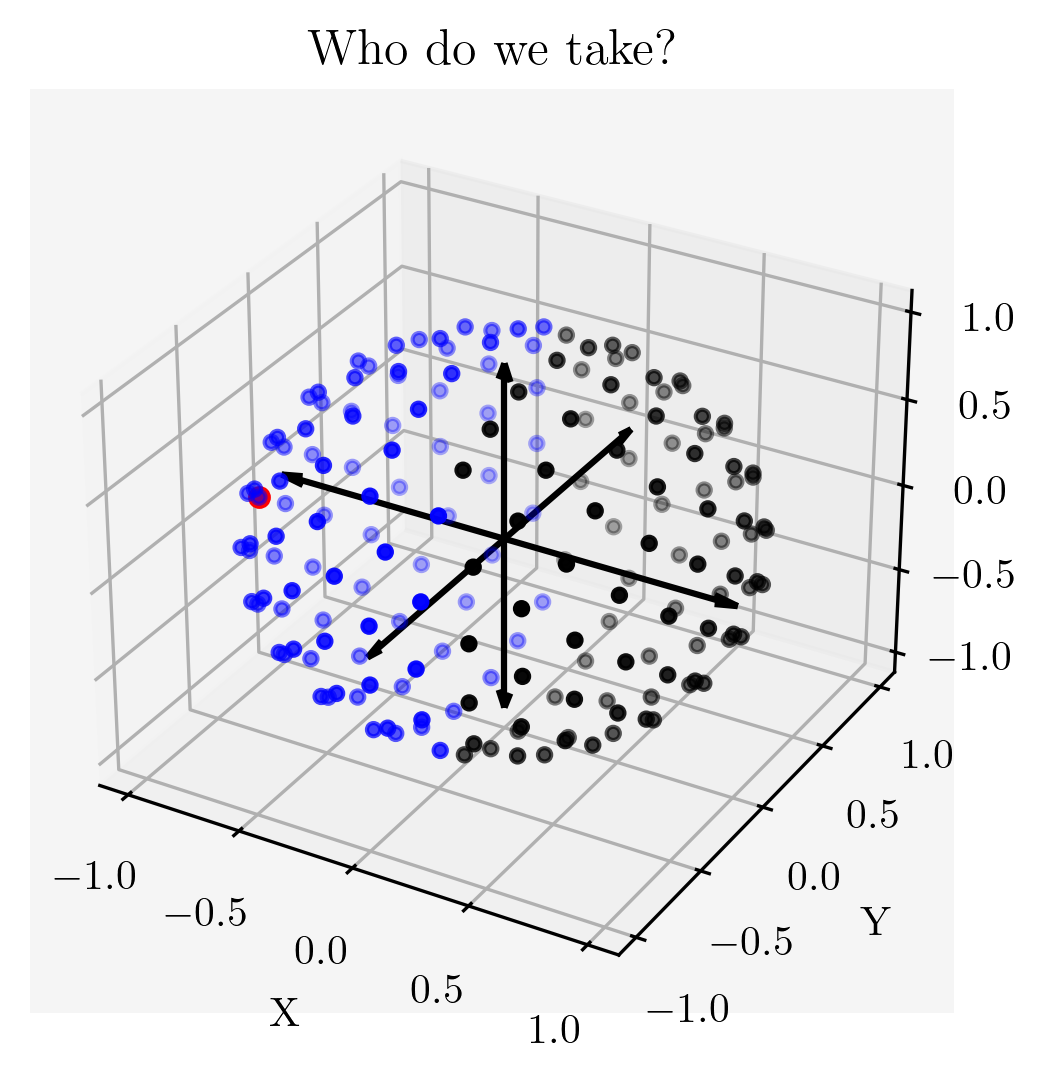

In [36]:
# Plot healpix with axis 
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.scatter(x_healpix, y_healpix, z_healpix, color = color_plot, s=10)
ax.scatter(xyz_selected[0], xyz_selected[1], xyz_selected[2], c = 'r')
ax.quiver(xar, yar, zar, x_wanted, y_wanted, z_wanted, arrow_length_ratio=0.1, color = 'k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Who do we take?')

In [ ]:
lum_n = np.zeros(len(x_arr))

for j in range(len(rays_T)):
    print('ray :', j)

    # if dot_product[j] == 0:
    #     continue

    for i in range(len(rays_cumulative_taus[j])):        
        # Temperature, Density and volume: np.array from near to the BH to far away. 
        # Thus we will use negative index in the for loop.
        # tau: np.array from outside to inside.
        reverse_idx = -i -1
        T = rays_T[j][reverse_idx]
        rho = rays_den[j][reverse_idx] 
        opt_depth = rays_cumulative_taus[j][i]
        cell_vol = volume[reverse_idx]

        for i_freq, n in enumerate(n_arr): #we need linearspace
            lum_n_cell = luminosity_n(T, rho, opt_depth, cell_vol, n)
            lum_n_cell *= dot_product[j]
            lum_n[i_freq] += lum_n_cell

# Normalise with the bolometric luminosity from red curve (FLD)
const_norm = normalisation(lum_n, x_arr, 3.822633793010264e+43)
lum_tilde_n = lum_n * const_norm
